# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

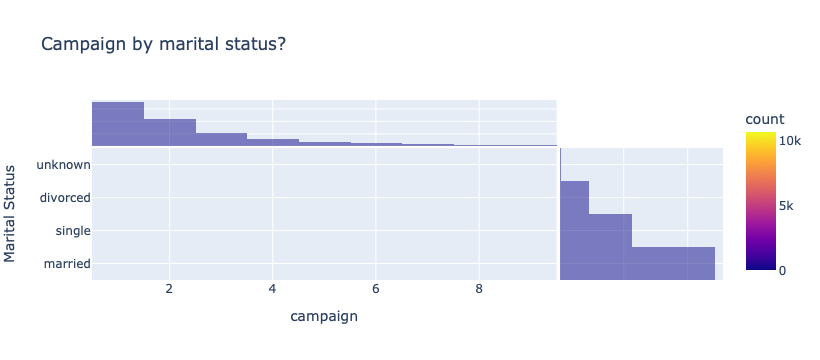

In [601]:
pl3= px.density_heatmap(df.query('campaign < 10'), x='campaign', y='marital',
                        marginal_x = "histogram", marginal_y = "histogram", 
                        labels={'MntWines':'Campaign', 'marital':'Marital Status'},
                        
                        title='Campaign by marital status?'
                       )
pl3.write_image('3.png')
pl3

### Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [371]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


import time
import warnings
warnings.simplefilter(action='ignore')


In [584]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [586]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [218]:
df.shape

(41188, 21)

### Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [221]:
# Cleanse the columns
df.rename(columns={'day_of_week':'weekday', 'poutcome':'outcome','emp.var.rate':'employment_rate', 'cons.price.idx':'consumer_price_idx', 'cons.conf.idx':'consumer_confidence_idx', 'nr.employed':'num_employees','y':'subscribed' }, inplace=True)

### Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Business Objective
#### The data is related with direct marketing campaigns of a Portuguese banking institution. 
#### The classification goal is to identify model to best predictif the client will subscribe a term deposit 

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      41188 non-null  int64  
 1   job                      41188 non-null  object 
 2   marital                  41188 non-null  object 
 3   education                41188 non-null  object 
 4   default                  41188 non-null  object 
 5   housing                  41188 non-null  object 
 6   loan                     41188 non-null  object 
 7   contact                  41188 non-null  object 
 8   month                    41188 non-null  object 
 9   weekday                  41188 non-null  object 
 10  duration                 41188 non-null  int64  
 11  campaign                 41188 non-null  int64  
 12  pdays                    41188 non-null  int64  
 13  previous                 41188 non-null  int64  
 14  outcome               

### Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [230]:
df.duplicated().sum()

12

In [232]:
# Drop duplicates
df.drop_duplicates(inplace=True)

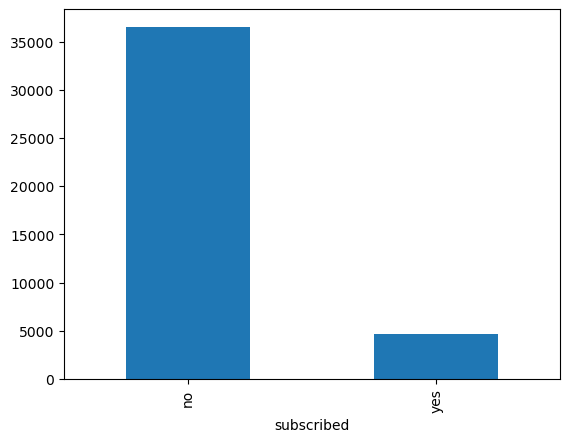

In [234]:
# Number of customers 
df['subscribed'].value_counts().plot.bar();

In [236]:
#Map categories to 0 or 1
subs_categories={'yes':1,'no': 0}                                        
df['subscribed']=df['subscribed'].map(subs_categories)

In [238]:
#Replace the dot in data with underscore
columns_to_clean = df.select_dtypes(include='object')
for col in columns_to_clean:
    df[col] = df[col].str.replace('.', '_', regex=False)

In [254]:
# Any missing data?
df.isna().mean().multiply(100) > 0

age                        False
job                        False
marital                    False
education                  False
default                    False
housing                    False
loan                       False
contact                    False
month                      False
weekday                    False
duration                   False
campaign                   False
pdays                      False
previous                   False
outcome                    False
employment_rate            False
consumer_price_idx         False
consumer_confidence_idx    False
euribor3m                  False
num_employees              False
subscribed                 False
dtype: bool

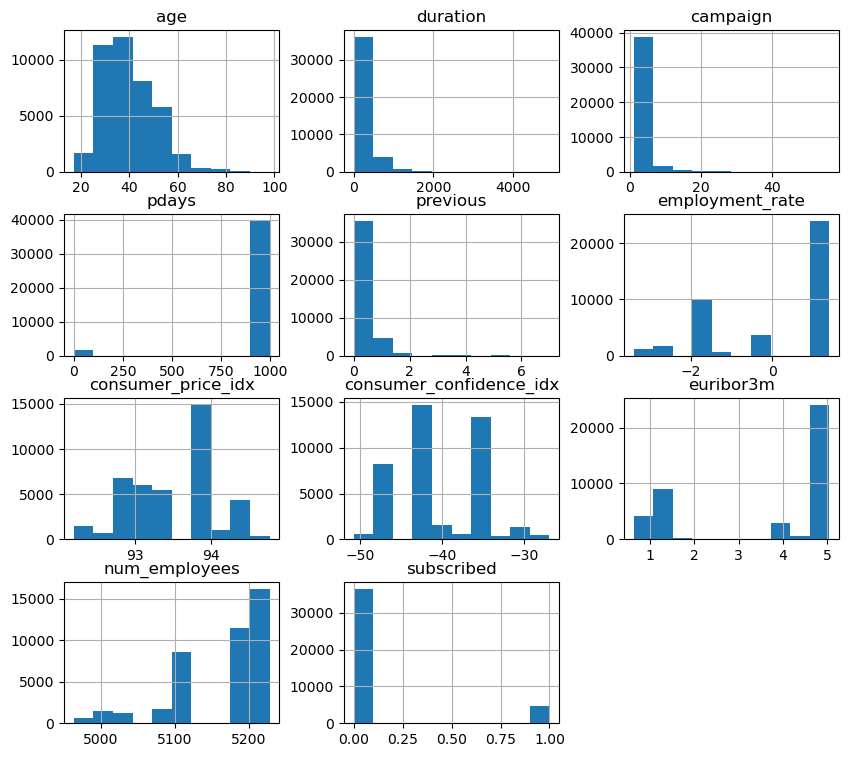

In [256]:
df.hist(figsize=(10,9));

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      41176 non-null  int64  
 1   job                      41176 non-null  object 
 2   marital                  41176 non-null  object 
 3   education                41176 non-null  object 
 4   default                  41176 non-null  object 
 5   housing                  41176 non-null  object 
 6   loan                     41176 non-null  object 
 7   contact                  41176 non-null  object 
 8   month                    41176 non-null  object 
 9   weekday                  41176 non-null  object 
 10  duration                 41176 non-null  int64  
 11  campaign                 41176 non-null  int64  
 12  pdays                    41176 non-null  int64  
 13  previous                 41176 non-null  int64  
 14  outcome                  41

In [275]:
categorical_features = ['weekday','month','job', 'marital', 'education','default','housing','loan','contact','outcome']
numerical_features = ['B']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
    ], remainder = StandardScaler() # scale the remaining features
)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [465]:
# Create Train and Test splits of data
X = df.drop(columns='subscribed')
y = df['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [467]:
# Define the data structures where we can store the results
train_score = []
test_score = []
accuracy_train_score = []
accuracy_test_score = []
fit_time = []

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [469]:
classifier_baseline = y_train.value_counts(normalize=True).max()
print(f"The model we generate should aim to beat", classifier_baseline*100, " %")


The model we generate should aim to beat 88.8457134926968  %


### A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [573]:
# Define extractor
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42))

In [473]:
#Logistic Regression
start_time = time.time()

lgr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', extractor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
]).fit(X_train, y_train)

train_score.append(precision_score(y_train, lgr_pipe.predict(X_train)))
test_score.append(precision_score(y_test, lgr_pipe.predict(X_test)))

accuracy_train_score.append(accuracy_score(y_train, lgr_pipe.predict(X_train)))
accuracy_test_score.append(accuracy_score(y_test, lgr_pipe.predict(X_test)))

lr_end_time = time.time() - start_time
fit_time.append(lr_end_time)

### Score the Model

What is the accuracy of your model?

In [475]:
lr_model_train_accuracy=roc_auc_score(y_train, lgr_pipe.predict_proba(X_train)[:, 1])
print(f" Model accuracy ", lr_model_train_accuracy)

 Model accuracy  0.9376104157769516


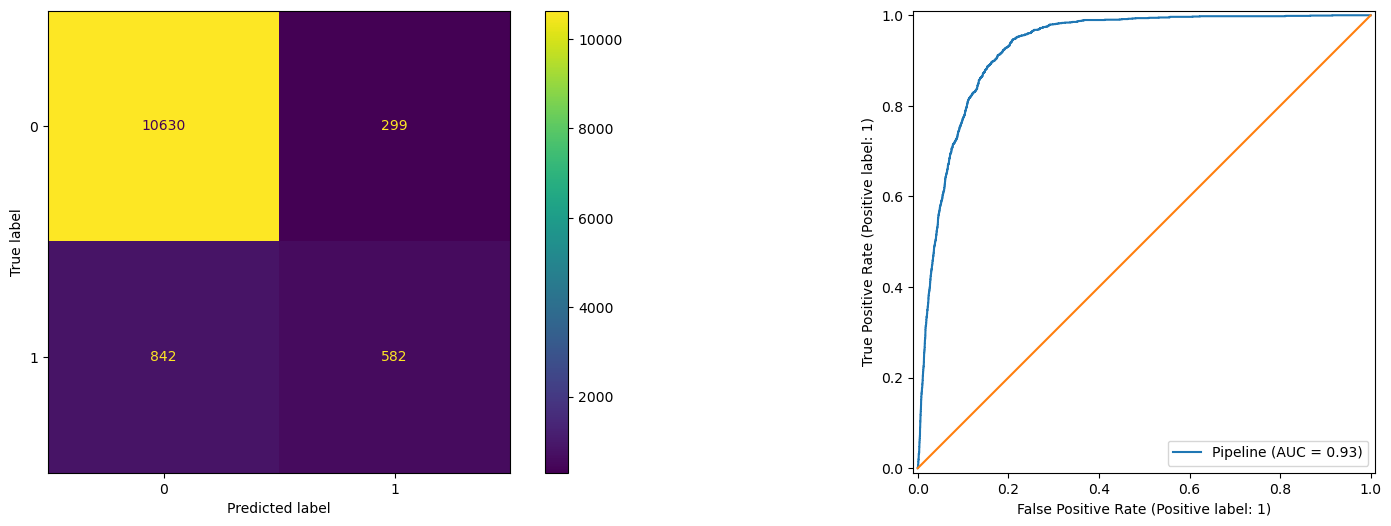

In [477]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]));

### Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [481]:
#KNN (With scaled data)
start_time = time.time()

knn_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=3))
]).fit(X_train, y_train)

train_score.append(precision_score(y_train, knn_pipe.predict(X_train)))
test_score.append(precision_score(y_test, knn_pipe.predict(X_test)))

accuracy_train_score.append(accuracy_score(y_train, knn_pipe.predict(X_train)))
accuracy_test_score.append(accuracy_score(y_test, knn_pipe.predict(X_test)))

knn_end_time = time.time() - start_time
fit_time.append(knn_end_time)

In [483]:
#SVC 
start_time = time.time()
svc_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear'))
]).fit(X_train, y_train)

train_score.append( precision_score(y_train, svc_pipe.predict(X_train)))
test_score.append( precision_score(y_test, svc_pipe.predict(X_test)))

accuracy_train_score.append(accuracy_score(y_train, svc_pipe.predict(X_train)))
accuracy_test_score.append(accuracy_score(y_test, svc_pipe.predict(X_test)))


svc_end_time = time.time() - start_time
fit_time.append(svc_end_time)

In [485]:
#Decision tree
start_time = time.time()

dtree_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(criterion='entropy', max_depth = 3))
]).fit(X_train, y_train)

# Predict and evaluate
train_score.append( precision_score(y_train, dtree_pipe.predict(X_train)))
test_score.append( precision_score(y_test, dtree_pipe.predict(X_test)))

accuracy_train_score.append(accuracy_score(y_train, dtree_pipe.predict(X_train)))
accuracy_test_score.append(accuracy_score(y_test, dtree_pipe.predict(X_test)))

# average end time
dtree_end_time = time.time() - start_time
fit_time.append(dtree_end_time)

In [487]:
res_dict = {'Model': ['Logistic Reg', 'KNN', 'SVC', 'DTree'],
           'Train Accuracy': train_score,
            'Test accuracy': train_score,
           'Train precision': accuracy_train_score,
            'Test precision': accuracy_test_score,
           'Avg fit time': fit_time}
results_df = pd.DataFrame(res_dict).set_index('Model')

print(type(results_df))
print(results_df.shape)

<class 'pandas.core.frame.DataFrame'>
(4, 5)


Text(0.5, 1.0, 'Decision Tree')

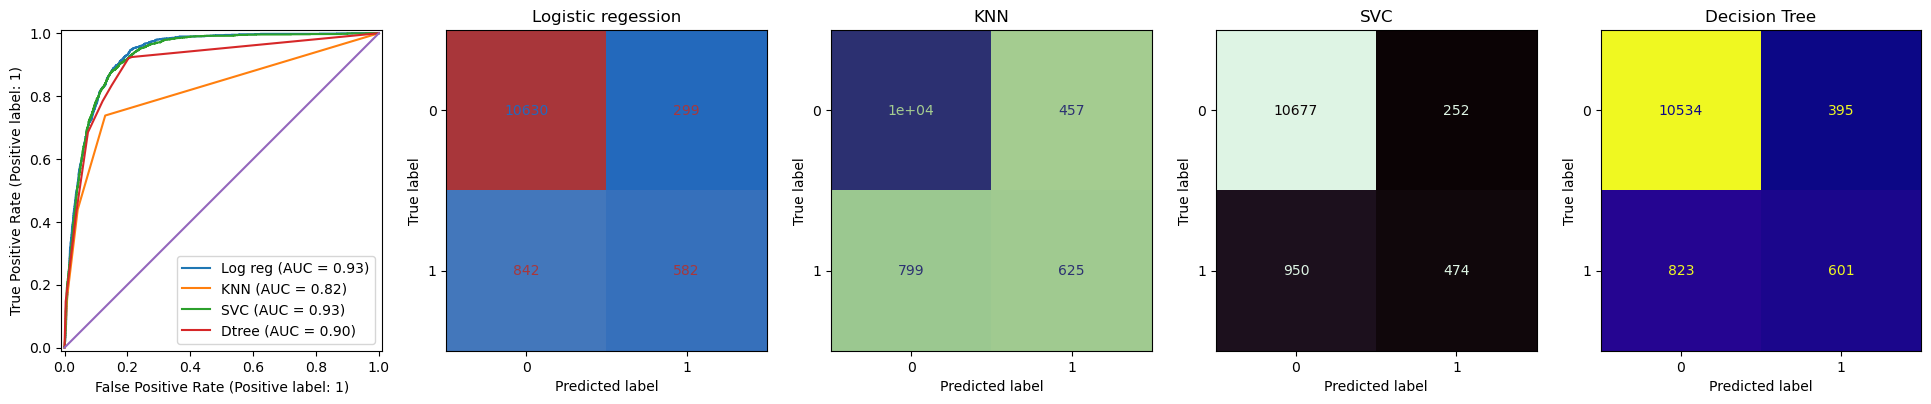

In [491]:
fig, ax = plt.subplots(1, 5, figsize = (24, 8))
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[1], cmap='vlag', colorbar=False)
ConfusionMatrixDisplay.from_estimator(knn_pipe, X_test, y_test, ax = ax[2], cmap='crest', colorbar=False)
ConfusionMatrixDisplay.from_estimator(svc_pipe, X_test, y_test, ax = ax[3], cmap='mako', colorbar=False)
ConfusionMatrixDisplay.from_estimator(dtree_pipe, X_test, y_test, ax = ax[4], cmap='plasma', colorbar=False)
RocCurveDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[0], name ='Log reg')
RocCurveDisplay.from_estimator(knn_pipe, X_test, y_test, ax = ax[0], name ='KNN')
RocCurveDisplay.from_estimator(svc_pipe, X_test, y_test, ax = ax[0], name='SVC')
RocCurveDisplay.from_estimator(dtree_pipe, X_test, y_test, ax = ax[0], name='Dtree')
ax[0].plot(np.array([0, 1]), np.array([0, 1]));
ax[1].set_title('Logistic regession')
ax[2].set_title('KNN')
ax[3].set_title('SVC')
ax[4].set_title('Decision Tree')

In [489]:
results_df

Train Accuracy  Test accuracy  Train precision  Test precision  \
Model                                                                          
Logistic Reg        0.671021       0.671021         0.912986        0.907634   
KNN                 0.784987       0.784987         0.940881        0.898324   
SVC                 0.667491       0.667491         0.907262        0.902696   
DTree               0.595249       0.595249         0.903480        0.901400   

              Avg fit time  
Model                       
Logistic Reg      3.495335  
KNN               2.621040  
SVC              26.229719  
DTree             0.278666

In [501]:
report = classification_report(y_test, lgr_pipe.predict(X_test))
print("\nLogistic Regression Classification Report:")
print(report)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10929
           1       0.66      0.41      0.50      1424

    accuracy                           0.91     12353
   macro avg       0.79      0.69      0.73     12353
weighted avg       0.90      0.91      0.90     12353



In [495]:
knn_report = classification_report(y_test, knn_pipe.predict(X_test))
print("\nKNN Regression Classification Report:")
print(knn_report)


KNN Regression Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     10929
           1       0.58      0.44      0.50      1424

    accuracy                           0.90     12353
   macro avg       0.75      0.70      0.72     12353
weighted avg       0.89      0.90      0.89     12353



In [499]:
report = classification_report(y_test, svc_pipe.predict(X_test))
print("\nSVC Regression Classification Report:")
print(report)


SVC Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10929
           1       0.65      0.33      0.44      1424

    accuracy                           0.90     12353
   macro avg       0.79      0.65      0.69     12353
weighted avg       0.89      0.90      0.89     12353



In [383]:
feature_names = lgr_pipe.named_steps['preprocessor'].get_feature_names_out() 
selected_features =feature_names[ [int(i[1:]) for i in lgr_pipe.named_steps['selector'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
model = 'Logistic Regression'
coef_df = pd.DataFrame({'Model': model, 'feature': clean_names, 'coefs': lgr_pipe.named_steps['classifier'].coef_[0]})
coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)
coef_df.head(10)

Model              feature     coefs
41  Logistic Regression      employment_rate  2.114177
8   Logistic Regression            month_mar  1.815022
37  Logistic Regression             duration  1.247586
35  Logistic Regression      outcome_failure  1.129188
42  Logistic Regression   consumer_price_idx  0.945934
36  Logistic Regression  outcome_nonexistent  0.610844
5   Logistic Regression            month_aug  0.593408
34  Logistic Regression    contact_telephone  0.589885
9   Logistic Regression            month_may  0.565586
44  Logistic Regression            euribor3m  0.486337

### Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [430]:
# Define the models and their hyperparameters
logreg1 = LogisticRegression()
knn1 = KNeighborsClassifier()
dtree1 = DecisionTreeClassifier()
svc1 = SVC()

# Hyperparameters for grid search
param_grid_logreg = {
    'classifier__C': [0.1, 1, 10, 100]
}
param_grid_knn = {
    'knn__n_neighbors': [1, 3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance']
}
param_grid_dtree = {
    'dtree__criterion': ['gini', 'entropy'],
    'dtree__max_depth': [5, 10, 20, 30, 40, 50]
}
param_grid_svc = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf']
}

In [434]:
# Logistic Regression
start_time = time.time()
lgr_pipe_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', extractor),
    ('classifier', LogisticRegression())
]).fit(X_train, y_train)
grid_search_logreg = GridSearchCV(lgr_pipe_1, param_grid_logreg, cv=5)
grid_search_logreg.fit(X_train, y_train)
logreg_time = time.time() - start_time
best_logreg = grid_search_logreg.best_estimator_
logreg_accuracy = accuracy_score(y_test, best_logreg.predict(X_test))


In [436]:
# K-Nearest Neighbors
start_time = time.time()
knn_pipe_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', extractor),
    ('knn', KNeighborsClassifier())
]).fit(X_train, y_train)
grid_search_knn = GridSearchCV(knn_pipe_1, param_grid_knn, cv=5)
grid_search_knn.fit(X_train, y_train)
knn_time = time.time() - start_time
best_knn = grid_search_knn.best_estimator_
knn_accuracy = accuracy_score(y_test, best_knn.predict(X_test))

In [440]:
# Decision Tree
start_time = time.time()
dtree_pipe_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', extractor),
    ('dtree', DecisionTreeClassifier())
]).fit(X_train, y_train)
grid_search_dt = GridSearchCV(dtree_pipe_1, param_grid_dtree, cv=5)
grid_search_dt.fit(X_train, y_train)  
dt_time = time.time() - start_time
best_dt = grid_search_dt.best_estimator_
dt_accuracy = accuracy_score(y_test, best_dt.predict(X_test))

In [442]:
# Support Vector Classifier
start_time = time.time()
svc_pipe_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', extractor),
    ('svc', SVC())
]).fit(X_train, y_train)
grid_search_svc = GridSearchCV(svc_pipe_1, param_grid_svc, cv=5)
grid_search_svc.fit(X_train, y_train)
svc_time = time.time() - start_time
best_svc = grid_search_svc.best_estimator_
svc_accuracy = accuracy_score(y_test, best_svc.predict(X_test))

In [444]:
# Store the results into an array
best_param = [grid_search_logreg.best_params_, grid_search_knn.best_params_, grid_search_dt.best_params_, grid_search_svc.best_params_]
accuracy = [logreg_accuracy, knn_accuracy, dt_accuracy, svc_accuracy]
avg_time = [logreg_time, knn_time, dt_time, svc_time]

In [446]:
res2_dict = {'model': ['Logistic Reg', 'KNN', 'DTree','SVC'],
                'best param': best_param, 
                 'accuracy': accuracy,
                 'avg. time': avg_time
            }
results2_df = pd.DataFrame(res2_dict).set_index('model')

In [515]:
pd.set_option('display.max_colwidth', None)
results2_df

best param  accuracy  \
model                                                                         
Logistic Reg                               {'classifier__C': 0.1}  0.906905   
KNN            {'knn__n_neighbors': 9, 'knn__weights': 'uniform'}  0.903181   
DTree         {'dtree__criterion': 'gini', 'dtree__max_depth': 5}  0.911358   
SVC                           {'svc__C': 1, 'svc__kernel': 'rbf'}  0.908119   

                avg. time  
model                      
Logistic Reg    52.233750  
KNN            114.921501  
DTree          124.874632  
SVC           1490.731626

In [540]:
# Create Train and Test splits of data without marital and default columns
X = df.drop(columns=['subscribed', 'marital','default'])
y = df['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [551]:
best_param_2 = [grid_search_logreg.best_params_, grid_search_knn.best_params_, grid_search_dt.best_params_, grid_search_svc.best_params_]
accuracy_2 = [logreg_accuracy, knn_accuracy, dt_accuracy, svc_accuracy]
avg_time_2 = [logreg_time, knn_time, dt_time, svc_time]

In [552]:
res3_dict = {'model': ['Logistic Reg', 'KNN', 'DTree','SVC'],
                'best param': best_param_2, 
                 'accuracy': accuracy_2,
                 'avg. time': avg_time_2
            }
results3_df = pd.DataFrame(res3_dict).set_index('model')

In [618]:
pd.set_option('display.max_colwidth', None)
results3_df

best param  accuracy  \
model                                                                         
Logistic Reg                                 {'classifier__C': 1}  0.907634   
KNN           {'knn__n_neighbors': 9, 'knn__weights': 'distance'}  0.902777   
DTree         {'dtree__criterion': 'gini', 'dtree__max_depth': 5}  0.911358   
SVC                           {'svc__C': 1, 'svc__kernel': 'rbf'}  0.908686   

                avg. time  
model                      
Logistic Reg    55.180267  
KNN            116.696281  
DTree          127.682742  
SVC           1442.138703

Text(0.5, 1.0, 'Decision Tree')

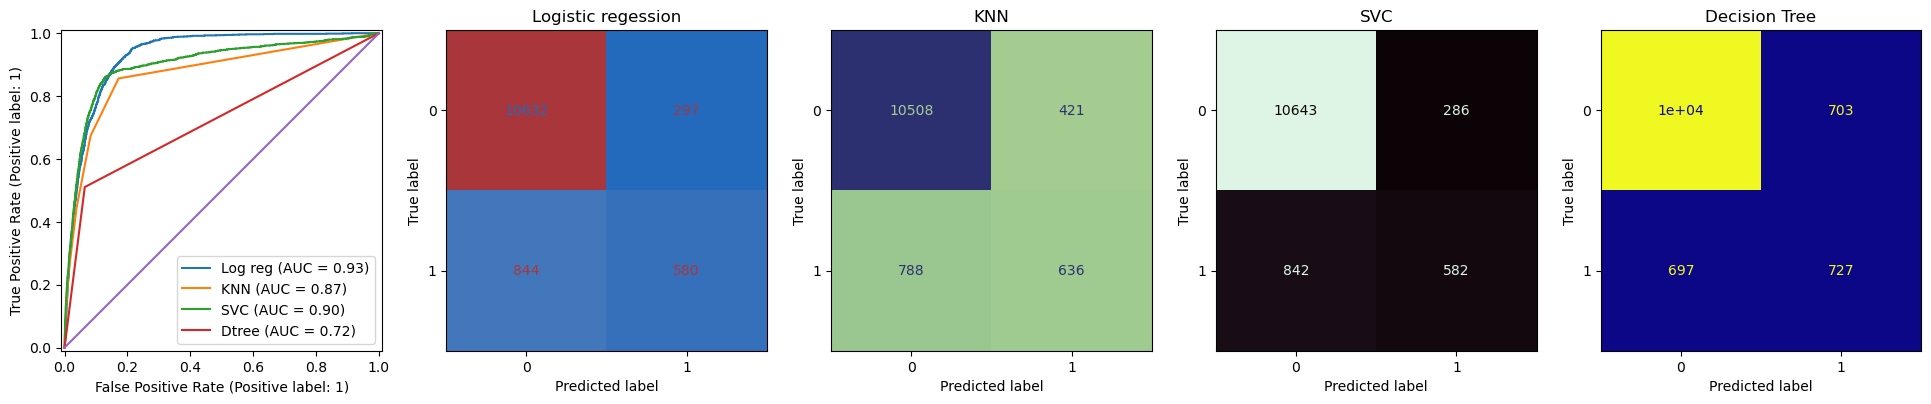

In [581]:
fig, ax = plt.subplots(1, 5, figsize = (24, 8))
ConfusionMatrixDisplay.from_estimator(lgr_pipe_1, X_test, y_test, ax = ax[1], cmap='vlag', colorbar=False)
ConfusionMatrixDisplay.from_estimator(knn_pipe_1, X_test, y_test, ax = ax[2], cmap='crest', colorbar=False)
ConfusionMatrixDisplay.from_estimator(svc_pipe_1, X_test, y_test, ax = ax[3], cmap='mako', colorbar=False)
ConfusionMatrixDisplay.from_estimator(dtree_pipe_1, X_test, y_test, ax = ax[4], cmap='plasma', colorbar=False)
RocCurveDisplay.from_estimator(lgr_pipe_1, X_test, y_test, ax = ax[0], name ='Log reg')
RocCurveDisplay.from_estimator(knn_pipe_1, X_test, y_test, ax = ax[0], name ='KNN')
RocCurveDisplay.from_estimator(svc_pipe_1, X_test, y_test, ax = ax[0], name='SVC')
RocCurveDisplay.from_estimator(dtree_pipe_1, X_test, y_test, ax = ax[0], name='Dtree')
ax[0].plot(np.array([0, 1]), np.array([0, 1]));
ax[1].set_title('Logistic regession')
ax[2].set_title('KNN')
ax[3].set_title('SVC')
ax[4].set_title('Decision Tree')

### Conclusion and Recommendations

# 
Headline: Logistic Regression is the winner!

The testing of different models showed that the Decision Tree classifier performs the best upon hyperparmeter tuning and with a max depth of 5 with 91.14%, however the AUC is only 72%, it does not makes the correct choice for the problem we are trying to solve.

Given the Logistic Regression is 90.69% accuracy and 93% AUC, which makes it the recommended model.
Given this model, improves upon the initial baseline performance of 88.85% and would be additive for the banks to utilize Logistic Regression.   

Recommendation:
This accuracy could be further improved with experimenting removing more features and testing out the results to find even better performance model. The banks can utilize the data and use it for marketing to the right set of customers at the right time.
